In [11]:
import torch

#Import models
from models.TimesNet import Model as TimesNet
from models.Nonstationary_Transformer import Model as NST
from models.Informer import Model as Informer

from tqdm import tqdm, trange

from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import time
from datetime import timedelta
import traceback

In [12]:
print(torch.__version__)
print(torch.version.cuda)

2.5.1
11.8


In [13]:
torch.cuda.is_available()

True

In [14]:
# Seeing that the GPU hase enough memory to run
torch.cuda.empty_cache()  # Frees unused memory
torch.cuda.memory_summary(device=None, abbreviated=False)  # Shows memory usage

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 2                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [15]:
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [16]:
print(torch.cuda.ipc_collect())

None


In [17]:
# Add this at the start of your code
torch.cuda.set_device(2)  # Switch to GPU 2
print(f"Using GPU: {torch.cuda.current_device()}")


Using GPU: 2


In [18]:
import subprocess
import re

def get_least_used_gpu():
    """Find the GPU with the most available memory using nvidia-smi."""
    try:
        # Run nvidia-smi and get memory info
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits,noheader"],
            stdout=subprocess.PIPE,
            text=True,
            check=True
        )
        
        # Parse output into a list of free memory values
        free_memory = [int(x) for x in result.stdout.strip().split("\n")]
        print(free_memory)
        
        # Find GPU with max free memory
        best_gpu = free_memory.index(max(free_memory))
        return best_gpu

    except Exception as e:
        print(f"Error getting GPU memory info: {e}")
        return 0  # Default to GPU 0 if there's an issue

# Get the best GPU with the most free memory
best_gpu = get_least_used_gpu()

# Set it for PyTorch
torch.cuda.set_device(best_gpu)
print(f"Using GPU: {torch.cuda.current_device()} (GPU {best_gpu})")


[1036, 11456, 19694]
Using GPU: 2 (GPU 2)


In [24]:
class TimeSeriesConfig:
    def __init__(self, model_type='nst'):
        # Common configurations for all models
        self.task_name = 'classification'
        self.seq_len = 401  # Your sequence length, for 5ms
        # self.seq_len = 101  # Your sequence length, for 50ms
        # self.seq_len = 18  # Your sequence length, for 250ms
        self.pred_len = 0   # Not used in classification
        self.label_len = 0  # Not used in classification
        
        # Input/Output dimensions
        self.enc_in = 1      # Number of input features
        self.dec_in = 1      # Not used in classification
        self.c_out = 1       # Not used in classification
        self.num_class = 5   # Number of classes
        
        # Training parameters
        self.dropout = 0.1
        self.embed = 'timeF'
        self.freq = 'h'
        self.batch_size = 32 # 8
        self.learning_rate = 1e-4
        self.num_epochs = 10
        
        # Other configs
        self.use_gpu = torch.cuda.is_available() #True if torch.cuda.is_available() else False
        self.checkpoint_dir = 'checkpoints'
        self.classes_names = ['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube']
        
        # Model specific configurations
        if model_type.lower() == 'nst':
            self._set_nst_config()
        elif model_type.lower() == 'timesnet':
            self._set_timesnet_config()
        elif model_type.lower() == 'informer':
            self._set_informer_config()
        else:
            raise ValueError(f"Unknown model type: {model_type}")
            
        self.model_name = f'{model_type.lower()}_classifier'
    
    def _set_nst_config(self):
        """Nonstationary Transformer specific configurations"""
        # Model architecture - Reduced dimensions
        self.d_model = 64      # Reduced from 256 to match TimesNet
        self.n_heads = 4       # Reduced from 8
        self.e_layers = 2
        self.d_layers = 1
        self.d_ff = 256       # Reduced from 2048
        self.factor = 5

        # Projector configs - Adjusted to match model size
        self.p_hidden_dims = [128, 64]  # Reduced from [256, 128]
        self.p_hidden_layers = 2

        # Embedding configs
        self.activation = 'gelu'
        self.output_attention = True
    
    def _set_timesnet_config(self):
        """TimesNet specific configurations"""
        # Model architecture
        self.d_model = 64
        self.e_layers = 2
        self.d_ff = 128
        
        # TimesNet specific
        self.top_k = 3
        self.num_kernels = 6
    
    def _set_informer_config(self):
        """Informer specific configurations"""
        # Model architecture
        self.d_model = 512
        self.n_heads = 8
        self.e_layers = 3
        self.d_layers = 2
        self.d_ff = 2048
        self.factor = 5  # probsparse factor
        self.distil = True  # whether to use distilling in encoder
        self.activation = 'gelu'
        self.embed = 'fixed'
        self.attn = 'prob'
        self.dropout = 0.05
        self.output_attention = False
        self.mix = True
        
    def print_config(self):
        """Print all configurations"""
        print("\nModel Configuration:")
        print("-" * 50)
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")
        print("-" * 50)


In [25]:
def train_classifier(train_loader, val_loader, config, model=None, start_epoch=0, best_val_acc=0):
    """
    Train the TimesNet for classification
    """
    # Start timing
    total_start_time = time.time()
    
    # Initialize model if not provided
    if model is None:
        if config.model_name == 'timesnet_classifier':
            model = TimesNet(config)
        elif config.model_name == 'nst_classifier':
            model = NST(config)
        elif config.model_name == 'informer_classifier':
            model = Informer(config)
        else:
            print("Invalid model type")
            return None
    
    # Add these debugging checks here
    print("=== Debugging Information ===")
    # Check input shapes and ranges
    for batch_x, batch_y in train_loader:
        print(f"Input shape: {batch_x.shape}")
        print(f"Label shape: {batch_y.shape}")
        print(f"Input range: {batch_x.min().item()} to {batch_x.max().item()}")
        break
    
    # Initialize weights if it's a new model
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
    
    if model is None:  # Only apply to new models
        model.apply(init_weights)
    print("=== End Debugging Info ===")    


    if config.use_gpu:
        model = model.cuda()
    
    # Define loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Initialize metrics storage
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
#     # Training loop
#     for epoch in range(start_epoch, config.num_epochs):
#         epoch_start_time = time.time()
#         model.train()
#         total_loss = 0
#         correct = 0
#         total = 0
    # Training loop with progress bar for epochs
    epoch_pbar = trange(start_epoch, config.num_epochs, desc='Training')
    for epoch in epoch_pbar:
        epoch_start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
#         for batch_x, batch_y in train_loader:
        # Progress bar for batches within each epoch
        batch_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False)
        for batch_x, batch_y in batch_pbar:
            optimizer.zero_grad()
            
            # Prepare data
            if config.use_gpu:
                batch_x = batch_x.float().cuda()
                batch_y = batch_y.long().cuda()
            
            # Create marking tensor with correct dimensions
            # batch_mark = torch.ones((batch_x.shape[0], batch_x.shape[1]), device=batch_x.device)
            
            # Forward pass
            outputs = model(
                x_enc=batch_x,
                x_mark_enc=None,#batch_mark,
                x_dec=None,
                x_mark_dec=None
            )
            
            loss = criterion(outputs, batch_y)
            
            if torch.isnan(loss):
                print("NaN detected!")
                print("Batch labels:", batch_y)
                print("Output values:", outputs)  # Add this to see model outputs
                print("Output shape:", outputs.shape)
                print("Loss value:", loss.item())

                return None,None
            
            # Backward pass
            loss.backward()
            optimizer.step()
            

            # if torch.isnan(loss):
            #     print("NaN detected!")
            #     print("Batch labels:", batch_y)
            #     print("Output values:", outputs)  # Add this to see model outputs
            #     print("Output shape:", outputs.shape)
            #     print("Loss value:", loss.item())
            #     return None, None

            # # Backward pass
            # loss.backward()
            # # Add gradient clipping here
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # optimizer.step() 


            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            total_loss += loss.item()
            
            # Update batch progress bar
            batch_pbar.set_postfix({
               'loss': f'{loss.item():.4f}',
               'acc': f'{(correct/total)*100:.2f}%'
            })
        
        # Calculate training metrics
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        val_pbar = tqdm(val_loader, desc='Validation', leave=False)
        
        with torch.no_grad():
            for batch_x, batch_y in val_pbar: #val_loader:
                if config.use_gpu:
                    batch_x = batch_x.float().cuda()
                    batch_y = batch_y.long().cuda()
                
                # batch_mark = torch.ones((batch_x.shape[0], batch_x.shape[1]), device=batch_x.device)
                
                outputs = model(
                    x_enc=batch_x,
                    x_mark_enc=None,#batch_mark,
                    x_dec=None,
                    x_mark_dec=None
                )
                
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                
                # Update validation progress bar
                val_pbar.set_postfix({
                   'loss': f'{loss.item():.4f}',
                   'acc': f'{(correct/total)*100:.2f}%'
                })
        
        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_accuracy)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            save_checkpoint(
                model, optimizer, epoch, best_val_acc, config,
                f'{config.model_name}_best.pth'
            )

        # Save regular checkpoint
        if (epoch + 1) % 5 == 0:  # Save every 5 epochs
            save_checkpoint(
                model, optimizer, epoch, best_val_acc, config,
                f'{config.model_name}_epoch_{epoch+1}.pth'
            )

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Update epoch progress bar
        epoch_pbar.set_postfix({
           'train_loss': f'{avg_train_loss:.4f}',
           'train_acc': f'{train_accuracy:.2f}%',
           'val_loss': f'{avg_val_loss:.4f}',
           'val_acc': f'{val_accuracy:.2f}%',
           'time': f'{timedelta(seconds=int(epoch_time))}'
        })
        
        print(f'Epoch {epoch+1}/{config.num_epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        print(f'Epoch time: {timedelta(seconds=epoch_time)}')
        print('----------------------------------------')
    
    # Calculate total training time
    total_time = time.time() - total_start_time
    print("\nTraining Complete!")
    print(f"Total training time: {timedelta(seconds=total_time)}")
    
    # Plot and save metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs, config)
    evaluate_model(model, val_loader, config)
    
    return model, best_val_acc


In [26]:
# def train_classifier(train_loader, val_loader, config, model=None, start_epoch=0, best_val_acc=0):
#     # Start timing
#     total_start_time = time.time()
    
#     # Set seeds for reproducibility
#     torch.manual_seed(42)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(42)
    
#     # Initialize model if not provided
#     if model is None:
#         if config.model_name == 'timesnet_classifier':
#             model = TimesNet(config)
#         elif config.model_name == 'nst_classifier':
#             model = NST(config)
#         else:
#             print("Invalid model type")
#             return None
        
#     if config.use_gpu:
#         model = model.cuda()
    
#     # Define loss and optimizer
#     criterion = torch.nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
#     # Add learning rate scheduler
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode='min', factor=0.5, patience=2, verbose=True
#     )
    
#     # Initialize metrics storage
#     train_losses = []
#     val_losses = []
#     train_accs = []
#     val_accs = []
    
#     # Training loop
#     for epoch in range(start_epoch, config.num_epochs):
#         epoch_start_time = time.time()
#         model.train()
#         total_loss = 0
#         correct = 0
#         total = 0
        
#         for batch_x, batch_y in train_loader:
#             optimizer.zero_grad()
            
#             # Prepare data
#             if config.use_gpu:
#                 batch_x = batch_x.float().cuda()
#                 batch_y = batch_y.long().cuda()
            
#             outputs = model(
#                 x_enc=batch_x,
#                 x_mark_enc=None,
#                 x_dec=None,
#                 x_mark_dec=None
#             )
            
#             loss = criterion(outputs, batch_y)
            
#             if torch.isnan(loss):
#                 print(f"NaN detected at epoch {epoch+1}!")
#                 print("Returning last best model...")
#                 return model, best_val_acc
            
#             # Backward pass
#             loss.backward()
#             # Add gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#             optimizer.step()
            
#             # Calculate accuracy
#             _, predicted = torch.max(outputs.data, 1)
#             total += batch_y.size(0)
#             correct += (predicted == batch_y).sum().item()
            
#             total_loss += loss.item()
        
#         # Calculate training metrics
#         avg_train_loss = total_loss / len(train_loader)
#         train_accuracy = 100 * correct / total
#         train_losses.append(avg_train_loss)
#         train_accs.append(train_accuracy)
        
#         # Validation
#         model.eval()
#         val_loss = 0
#         correct = 0
#         total = 0
        
#         with torch.no_grad():
#             for batch_x, batch_y in val_loader:
#                 if config.use_gpu:
#                     batch_x = batch_x.float().cuda()
#                     batch_y = batch_y.long().cuda()
                
#                 outputs = model(
#                     x_enc=batch_x,
#                     x_mark_enc=None,
#                     x_dec=None,
#                     x_mark_dec=None
#                 )
                
#                 loss = criterion(outputs, batch_y)
#                 val_loss += loss.item()
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += batch_y.size(0)
#                 correct += (predicted == batch_y).sum().item()
        
#         # Calculate validation metrics
#         avg_val_loss = val_loss / len(val_loader)
#         val_accuracy = 100 * correct / total
#         val_losses.append(avg_val_loss)
#         val_accs.append(val_accuracy)
        
#         # Step the scheduler using validation loss
#         scheduler.step(avg_val_loss)
        
#         # Save best model
#         if val_accuracy > best_val_acc:
#             best_val_acc = val_accuracy
#             save_checkpoint(
#                 model, optimizer, epoch, best_val_acc, config,
#                 f'{config.model_name}_best.pth'
#             )
        
#         # Save regular checkpoint
#         if (epoch + 1) % 5 == 0:  # Save every 5 epochs
#             save_checkpoint(
#                 model, optimizer, epoch, best_val_acc, config,
#                 f'{config.model_name}_epoch_{epoch+1}.pth'
#             )
        
#         # Calculate epoch time
#         epoch_time = time.time() - epoch_start_time
        
#         print(f'Epoch {epoch+1}/{config.num_epochs}')
#         print(f'Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
#         print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
#         print(f'Epoch time: {timedelta(seconds=epoch_time)}')
#         print('----------------------------------------')
    
#     # Calculate total training time
#     total_time = time.time() - total_start_time
#     print("\nTraining Complete!")
#     print(f"Total training time: {timedelta(seconds=total_time)}")
    
#     # Plot and save metrics
#     plot_metrics(train_losses, val_losses, train_accs, val_accs, config)
#     evaluate_model(model, val_loader, config)
    
#     return model, best_val_acc

In [27]:
def prepare_data(X, y, config, val_split=0.2):
    batch_size=config.batch_size
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_split, random_state=32, stratify=y
    )
    
    # Create datasets
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    
    # Adjust DataLoader settings based on device
    loader_args = {
        'batch_size': batch_size,
        'num_workers': 4 if torch.cuda.is_available() else 2,
        'pin_memory': torch.cuda.is_available(),
    }
    
    train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_args)
    
    return train_loader, val_loader

def plot_metrics(train_losses, val_losses, train_accs, val_accs, config):
    """Plot and save training metrics"""
    save_dir=config.checkpoint_dir
    try:
        # Create directory if it doesn't exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Created directory: {save_dir}")
        
        print("\nPlotting Training Metrics...")
        plt.figure(figsize=(12, 5))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        
        
        # Save path with full directory
        save_path = os.path.join(save_dir, f'{config.model_name}_training_metrics.png')
        print(f"Saving metrics plot to: {save_path}")
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print("Successfully saved metrics plot")
        
        
        # Display the plot
        plt.show()
        
        #close
        plt.close()
        
    except Exception as e:
        print(f"Error in plotting metrics: {str(e)}")
        import traceback
        traceback.print_exc()


def plot_confusion_matrix(y_true, y_pred, config):
    """Plot and save confusion matrix (both raw and percentage-normalized)."""
    save_dir = config.checkpoint_dir
    classes = config.classes_names

    try:
        # Ensure save directory exists
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Created directory: {save_dir}")

        print("\nCreating confusion matrices...")
        
        # Compute confusion matrices
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize row-wise
        cm_norm_percent = cm_norm * 100  # Convert to percentages

        def plot_and_save(cm, title, filename, normalize=False):
            """Helper function to plot and save a confusion matrix."""
            try:
                plt.figure(figsize=(10, 8))
                plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
                plt.title(title)
                plt.colorbar()

                # Class labels
                tick_marks = np.arange(len(classes))
                plt.xticks(tick_marks, classes, rotation=45, ha='right')
                plt.yticks(tick_marks, classes)

                # Text annotations
                for i, j in np.ndindex(cm.shape):
                    value = cm[i, j]
                    if normalize:
                        plt.text(j, i, f"{value:.1f}%",  # Correct percentage formatting
                                 horizontalalignment="center",
                                 color="white" if value > cm.max() / 2 else "black")
                    else:
                        plt.text(j, i, f"{int(value)}",  # Raw count values
                                 horizontalalignment="center",
                                 color="white" if value > cm.max() / 2 else "black")

                plt.tight_layout()
                plt.ylabel('True label')
                plt.xlabel('Predicted label')

                # Save figure
                save_path = os.path.join(save_dir, filename)
                plt.savefig(save_path, bbox_inches='tight', dpi=300)
                print(f"Successfully saved: {save_path}")

                # Display the plot
                plt.show()
                plt.close()

            except Exception as e:
                print(f"Error in plotting {title}: {str(e)}")
                traceback.print_exc()

        # Plot and save raw confusion matrix
        plot_and_save(cm, "Confusion Matrix (Counts)", f"{config.model_name}_confusion_matrix.png", normalize=False)

        # Plot and save normalized confusion matrix in percentages
        plot_and_save(cm_norm_percent, "Confusion Matrix (Percentage)", f"{config.model_name}_confusion_matrix_percent.png", normalize=True)

    except Exception as e:
        print(f"Error in creating confusion matrices: {str(e)}")
        traceback.print_exc()


def save_checkpoint(model, optimizer, epoch, best_val_acc, config, filename):
    """Save model checkpoint"""
    # Create directory if it doesn't exist
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    
    # Print for debugging
    print(f"Saving checkpoint to {os.path.join(config.checkpoint_dir, filename)}")
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_val_acc': best_val_acc,
        'config': config
    }
    
    try:
        torch.save(checkpoint, os.path.join(config.checkpoint_dir, filename))
        print(f"Successfully saved checkpoint")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")

def load_checkpoint(checkpoint_path, model=None, optimizer=None):
    """Load model checkpoint"""
    checkpoint = torch.load(checkpoint_path)
    
    if model is None:
        config = checkpoint['config']
        model = Model(config)
        
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer, checkpoint['epoch'], checkpoint['best_val_acc'], checkpoint['config']

def evaluate_model(model, val_loader, config):
    """
    Evaluate the model on test data
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        config: Configuration object
        classes: List of class names (optional)
    """
    
    # Start timing
    start_time = time.time()
    
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            if config.use_gpu:
                batch_x = batch_x.float().cuda()
                batch_y = batch_y.long().cuda()
            
            # Create marking tensor with correct dimensions (batch_size, seq_len, 1)
            # batch_mark = torch.ones((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2]), device=batch_x.device)

            outputs = model(
                x_enc=batch_x,
                x_mark_enc= None,#batch_mark,
                x_dec=None,
                x_mark_dec=None
            )
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Val Accuracy: {accuracy:.2f}%')
    
    end_time = time.time()
    eval_time = end_time - start_time
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, config)
    
    print(f"\nEvaluation Complete!")
    print(f"Total evaluation time: {timedelta(seconds=eval_time)}")
    
    return accuracy

In [28]:
def drop_unused_features(df, num_features, pos):
    """
    Drops all columns except those at positions pos and then repeats for every num_features columns
    """
    # Get total number of columns
    total_cols = df.shape[1]
    # Calculate how many groups of 9 features we have
    num_groups = total_cols // num_features
    
    # Create a list of column indices to keep
    cols_to_keep = []
    for i in range(num_groups):
        inx = i * num_features + pos
        cols_to_keep.append(inx)
    
    # Keep only the selected columns
    df = df.iloc[:, cols_to_keep]
    reshaped_df = df.values.reshape(df.shape[0], df.shape[1], 1)
    
    return reshaped_df

# feature_path = r"/home/chanan/Time-Series-Library/pretraining-20250212T212437Z-001/pretraining/Dataset/5ms/4.289/features.csv"
# label_path = r"/home/chanan/Time-Series-Library/pretraining-20250212T212437Z-001/pretraining/Dataset/5ms/4.289/labels.csv"
feature_path = r'/home/chanan/Dataset/5ms/2/5 classes/features.csv'
label_path = r'/home/chanan/Dataset/5ms/2/5 classes/labels.csv'

feature_df = pd.read_csv(filepath_or_buffer=feature_path)
label_df = pd.read_csv(filepath_or_buffer=label_path)

reshaped_labels = label_df.values.reshape(-1)
print(reshaped_labels.shape)

# Clean the labels
def prepare_label(labels):
#     reshaped_labels = labels.values.reshape(-1)
    # Extract just the first number from each label string
    cleaned = np.array([int(label.split()[1]) for label in labels])
    y = cleaned.astype(np.int64)
    if len(y.shape) > 1:
        y = y.ravel()  # Flatten if needed
    return y

pos = 1
num_features = 9 
X = drop_unused_features(feature_df, num_features, pos)

y = prepare_label(reshaped_labels)  # Convert to int64 for PyTorch's CrossEntropyLoss

print(X.shape)
print(y.shape)
# print(y.shape)
# print(y)
# print(X)


(5869,)
(5869, 401, 1)
(5869,)


In [29]:
# Usage example:
def create_model(config_type='nst'):
    """Create model with specified configuration"""
    config = TimeSeriesConfig(model_type=config_type)
    
    if config.model_name == 'timesnet_classifier':
            model = TimesNet(config)
    elif config.model_name == 'nst_classifier':
        model = NST(config)
    elif config.model_name == 'informer_classifier':
        model = Informer(config)
    else:
        print("Invalid model type")
        return None
    return model, config



In [30]:
# For NST model
nst_model, nst_config = create_model('nst')
nst_config.print_config()


Model Configuration:
--------------------------------------------------
task_name: classification
seq_len: 401
pred_len: 0
label_len: 0
enc_in: 1
dec_in: 1
c_out: 1
num_class: 5
dropout: 0.1
embed: timeF
freq: h
batch_size: 32
learning_rate: 0.0001
num_epochs: 10
use_gpu: True
checkpoint_dir: checkpoints
classes_names: ['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube']
d_model: 64
n_heads: 4
e_layers: 2
d_layers: 1
d_ff: 256
factor: 5
p_hidden_dims: [128, 64]
p_hidden_layers: 2
activation: gelu
output_attention: True
model_name: nst_classifier
--------------------------------------------------


In [31]:
# For TimesNet model
timesnet_model, timesnet_config = create_model('timesnet')
timesnet_config.print_config()


Model Configuration:
--------------------------------------------------
task_name: classification
seq_len: 401
pred_len: 0
label_len: 0
enc_in: 1
dec_in: 1
c_out: 1
num_class: 5
dropout: 0.1
embed: timeF
freq: h
batch_size: 32
learning_rate: 0.0001
num_epochs: 10
use_gpu: True
checkpoint_dir: checkpoints
classes_names: ['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube']
d_model: 64
e_layers: 2
d_ff: 128
top_k: 3
num_kernels: 6
model_name: timesnet_classifier
--------------------------------------------------


In [32]:
informer_model, informer_config = create_model('informer')
informer_config.print_config()


Model Configuration:
--------------------------------------------------
task_name: classification
seq_len: 401
pred_len: 0
label_len: 0
enc_in: 1
dec_in: 1
c_out: 1
num_class: 5
dropout: 0.05
embed: fixed
freq: h
batch_size: 32
learning_rate: 0.0001
num_epochs: 10
use_gpu: True
checkpoint_dir: checkpoints
classes_names: ['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube']
d_model: 512
n_heads: 8
e_layers: 3
d_layers: 2
d_ff: 2048
factor: 5
distil: True
activation: gelu
attn: prob
output_attention: False
mix: True
model_name: informer_classifier
--------------------------------------------------


In [33]:
# Train NST model
train_loader, val_loader = prepare_data(X, y, informer_config)

=== Debugging Information ===
Input shape: torch.Size([32, 401, 1])
Label shape: torch.Size([32])
Input range: 0.0 to 115541.0
=== End Debugging Info ===


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/informer_classifier_best.pth


Training:  10%|█         | 1/10 [00:17<02:35, 17.27s/it, train_loss=0.6544, train_acc=81.09%, val_loss=0.3081, val_acc=89.86%, time=0:00:17]

Successfully saved checkpoint
Epoch 1/10
Training Loss: 0.6544, Accuracy: 81.09%
Validation Loss: 0.3081, Accuracy: 89.86%
Epoch time: 0:00:17.270307
----------------------------------------


Saving checkpoint to checkpoints/informer_classifier_best.pth


Training:  20%|██        | 2/10 [00:34<02:16, 17.02s/it, train_loss=0.2449, train_acc=92.33%, val_loss=0.3209, val_acc=91.48%, time=0:00:16]

Successfully saved checkpoint
Epoch 2/10
Training Loss: 0.2449, Accuracy: 92.33%
Validation Loss: 0.3209, Accuracy: 91.48%
Epoch time: 0:00:16.831038
----------------------------------------


Training:  30%|███       | 3/10 [00:50<01:56, 16.64s/it, train_loss=0.2386, train_acc=92.91%, val_loss=0.4606, val_acc=89.18%, time=0:00:16]

Epoch 3/10
Training Loss: 0.2386, Accuracy: 92.91%
Validation Loss: 0.4606, Accuracy: 89.18%
Epoch time: 0:00:16.187964
----------------------------------------


Training:  40%|████      | 4/10 [01:06<01:39, 16.53s/it, train_loss=0.2123, train_acc=93.84%, val_loss=0.4217, val_acc=88.25%, time=0:00:16]

Epoch 4/10
Training Loss: 0.2123, Accuracy: 93.84%
Validation Loss: 0.4217, Accuracy: 88.25%
Epoch time: 0:00:16.359863
----------------------------------------


Saving checkpoint to checkpoints/informer_classifier_best.pth
Successfully saved checkpoint
Saving checkpoint to checkpoints/informer_classifier_epoch_5.pth


Training:  50%|█████     | 5/10 [01:24<01:24, 16.96s/it, train_loss=0.1357, train_acc=95.95%, val_loss=0.3840, val_acc=92.33%, time=0:00:17]

Successfully saved checkpoint
Epoch 5/10
Training Loss: 0.1357, Accuracy: 95.95%
Validation Loss: 0.3840, Accuracy: 92.33%
Epoch time: 0:00:17.725440
----------------------------------------


Training:  60%|██████    | 6/10 [01:40<01:06, 16.72s/it, train_loss=0.1136, train_acc=96.87%, val_loss=0.3832, val_acc=92.08%, time=0:00:16]

Epoch 6/10
Training Loss: 0.1136, Accuracy: 96.87%
Validation Loss: 0.3832, Accuracy: 92.08%
Epoch time: 0:00:16.248786
----------------------------------------


Training:  70%|███████   | 7/10 [01:56<00:49, 16.55s/it, train_loss=0.0872, train_acc=97.44%, val_loss=0.3876, val_acc=91.31%, time=0:00:16]

Epoch 7/10
Training Loss: 0.0872, Accuracy: 97.44%
Validation Loss: 0.3876, Accuracy: 91.31%
Epoch time: 0:00:16.201478
----------------------------------------


Training:  80%|████████  | 8/10 [02:12<00:32, 16.39s/it, train_loss=0.0926, train_acc=97.40%, val_loss=0.5541, val_acc=89.44%, time=0:00:16]

Epoch 8/10
Training Loss: 0.0926, Accuracy: 97.40%
Validation Loss: 0.5541, Accuracy: 89.44%
Epoch time: 0:00:16.040722
----------------------------------------


Training:  90%|█████████ | 9/10 [02:29<00:16, 16.34s/it, train_loss=0.0970, train_acc=97.17%, val_loss=0.5381, val_acc=89.27%, time=0:00:16]

Epoch 9/10
Training Loss: 0.0970, Accuracy: 97.17%
Validation Loss: 0.5381, Accuracy: 89.27%
Epoch time: 0:00:16.217901
----------------------------------------


Saving checkpoint to checkpoints/informer_classifier_epoch_10.pth


Training: 100%|██████████| 10/10 [02:46<00:00, 16.62s/it, train_loss=0.1006, train_acc=97.34%, val_loss=0.4567, val_acc=92.33%, time=0:00:17]

Successfully saved checkpoint
Epoch 10/10
Training Loss: 0.1006, Accuracy: 97.34%
Validation Loss: 0.4567, Accuracy: 92.33%
Epoch time: 0:00:17.111043
----------------------------------------

Training Complete!
Total training time: 0:02:46.979531

Plotting Training Metrics...
Saving metrics plot to: checkpoints/informer_classifier_training_metrics.png


Successfully saved metrics plot


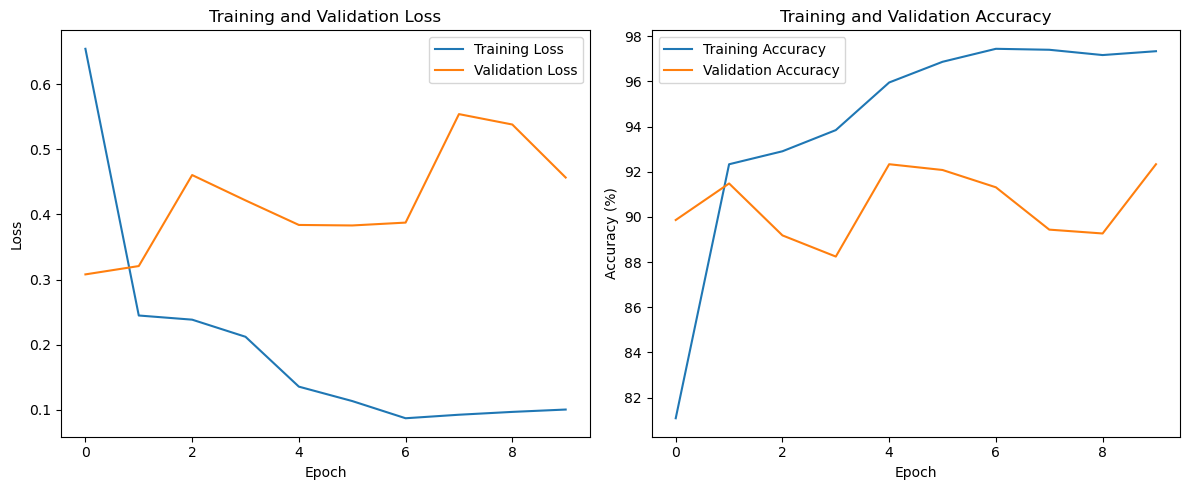

Val Accuracy: 92.84%

Creating confusion matrices...
Successfully saved: checkpoints/informer_classifier_confusion_matrix.png


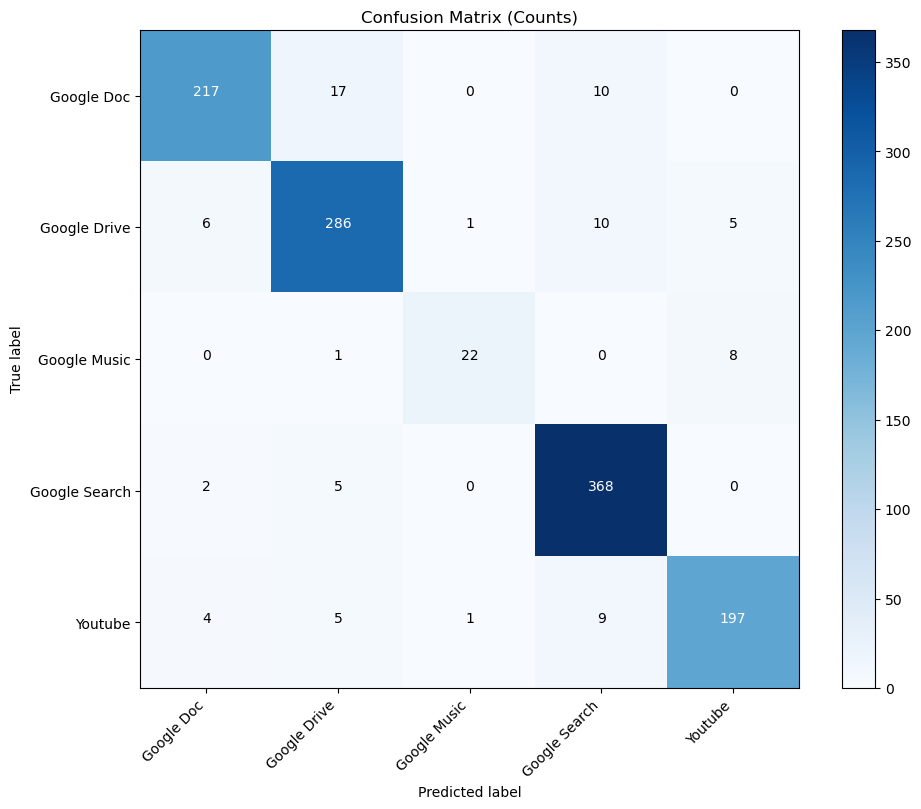

Successfully saved: checkpoints/informer_classifier_confusion_matrix_percent.png


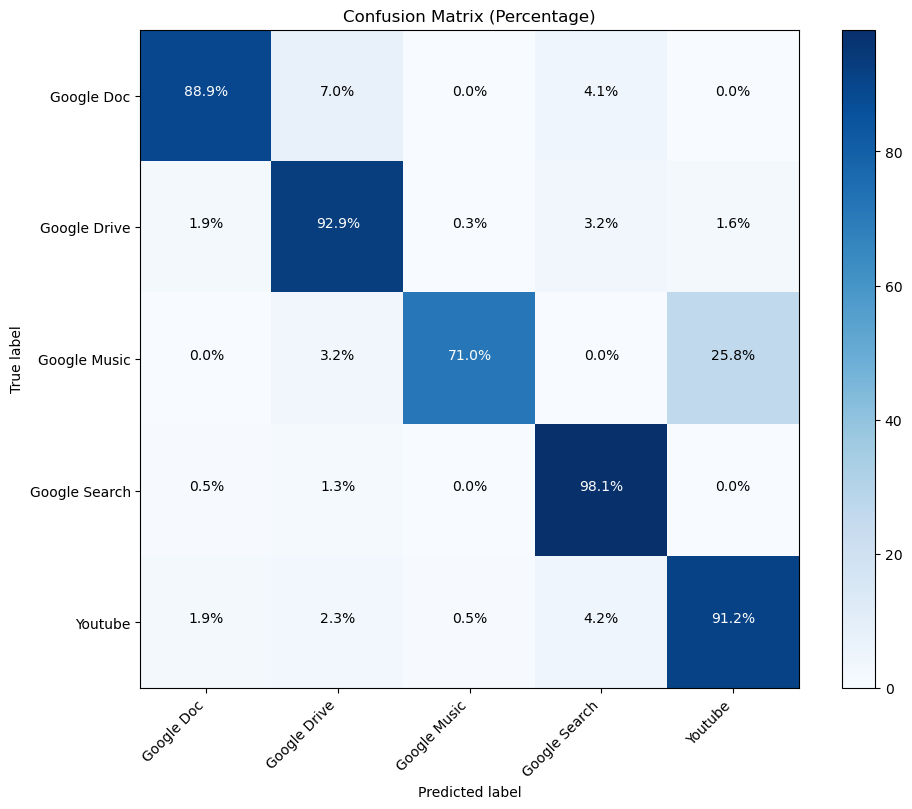


Evaluation Complete!
Total evaluation time: 0:00:01.623307


In [34]:
informer_model, informer_best_val_acc = train_classifier(train_loader, val_loader, informer_config)

In [35]:
# To free more spcae
del informer_model, informer_best_val_acc 

=== Debugging Information ===
Input shape: torch.Size([32, 401, 1])
Label shape: torch.Size([32])
Input range: 0.0 to 117534.0
=== End Debugging Info ===


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/timesnet_classifier_best.pth


Training:  10%|█         | 1/10 [00:33<05:01, 33.53s/it, train_loss=0.5543, train_acc=80.40%, val_loss=0.3333, val_acc=90.37%, time=0:00:33]

Successfully saved checkpoint
Epoch 1/10
Training Loss: 0.5543, Accuracy: 80.40%
Validation Loss: 0.3333, Accuracy: 90.37%
Epoch time: 0:00:33.525767
----------------------------------------


Saving checkpoint to checkpoints/timesnet_classifier_best.pth


Training:  20%|██        | 2/10 [01:06<04:27, 33.48s/it, train_loss=0.2292, train_acc=93.06%, val_loss=0.2297, val_acc=93.61%, time=0:00:33]

Successfully saved checkpoint
Epoch 2/10
Training Loss: 0.2292, Accuracy: 93.06%
Validation Loss: 0.2297, Accuracy: 93.61%
Epoch time: 0:00:33.439480
----------------------------------------


Training:  30%|███       | 3/10 [01:40<03:53, 33.32s/it, train_loss=0.1749, train_acc=95.14%, val_loss=0.2296, val_acc=93.61%, time=0:00:33]

Epoch 3/10
Training Loss: 0.1749, Accuracy: 95.14%
Validation Loss: 0.2296, Accuracy: 93.61%
Epoch time: 0:00:33.119582
----------------------------------------


Saving checkpoint to checkpoints/timesnet_classifier_best.pth


Training:  40%|████      | 4/10 [02:13<03:21, 33.52s/it, train_loss=0.1315, train_acc=96.10%, val_loss=0.1961, val_acc=94.55%, time=0:00:33]

Successfully saved checkpoint
Epoch 4/10
Training Loss: 0.1315, Accuracy: 96.10%
Validation Loss: 0.1961, Accuracy: 94.55%
Epoch time: 0:00:33.823080
----------------------------------------


Saving checkpoint to checkpoints/timesnet_classifier_epoch_5.pth


Training:  50%|█████     | 5/10 [02:47<02:48, 33.66s/it, train_loss=0.1064, train_acc=97.06%, val_loss=0.2008, val_acc=93.87%, time=0:00:33]

Successfully saved checkpoint
Epoch 5/10
Training Loss: 0.1064, Accuracy: 97.06%
Validation Loss: 0.2008, Accuracy: 93.87%
Epoch time: 0:00:33.897760
----------------------------------------


Training:  60%|██████    | 6/10 [03:21<02:14, 33.62s/it, train_loss=0.1007, train_acc=97.23%, val_loss=0.2039, val_acc=93.87%, time=0:00:33]

Epoch 6/10
Training Loss: 0.1007, Accuracy: 97.23%
Validation Loss: 0.2039, Accuracy: 93.87%
Epoch time: 0:00:33.542075
----------------------------------------


Training:  70%|███████   | 7/10 [03:54<01:40, 33.53s/it, train_loss=0.0828, train_acc=97.89%, val_loss=0.1868, val_acc=94.21%, time=0:00:33]

Epoch 7/10
Training Loss: 0.0828, Accuracy: 97.89%
Validation Loss: 0.1868, Accuracy: 94.21%
Epoch time: 0:00:33.344508
----------------------------------------


Training:  80%|████████  | 8/10 [04:28<01:07, 33.53s/it, train_loss=0.0610, train_acc=98.45%, val_loss=0.1996, val_acc=93.95%, time=0:00:33]

Epoch 8/10
Training Loss: 0.0610, Accuracy: 98.45%
Validation Loss: 0.1996, Accuracy: 93.95%
Epoch time: 0:00:33.534815
----------------------------------------


Training:  90%|█████████ | 9/10 [05:01<00:33, 33.52s/it, train_loss=0.0673, train_acc=98.00%, val_loss=0.2071, val_acc=93.95%, time=0:00:33]

Epoch 9/10
Training Loss: 0.0673, Accuracy: 98.00%
Validation Loss: 0.2071, Accuracy: 93.95%
Epoch time: 0:00:33.481615
----------------------------------------


Saving checkpoint to checkpoints/timesnet_classifier_epoch_10.pth


Training: 100%|██████████| 10/10 [05:35<00:00, 33.57s/it, train_loss=0.0510, train_acc=98.70%, val_loss=0.1811, val_acc=94.38%, time=0:00:33]

Successfully saved checkpoint
Epoch 10/10
Training Loss: 0.0510, Accuracy: 98.70%
Validation Loss: 0.1811, Accuracy: 94.38%
Epoch time: 0:00:33.984833
----------------------------------------

Training Complete!
Total training time: 0:05:35.977202

Plotting Training Metrics...
Saving metrics plot to: checkpoints/timesnet_classifier_training_metrics.png


Successfully saved metrics plot


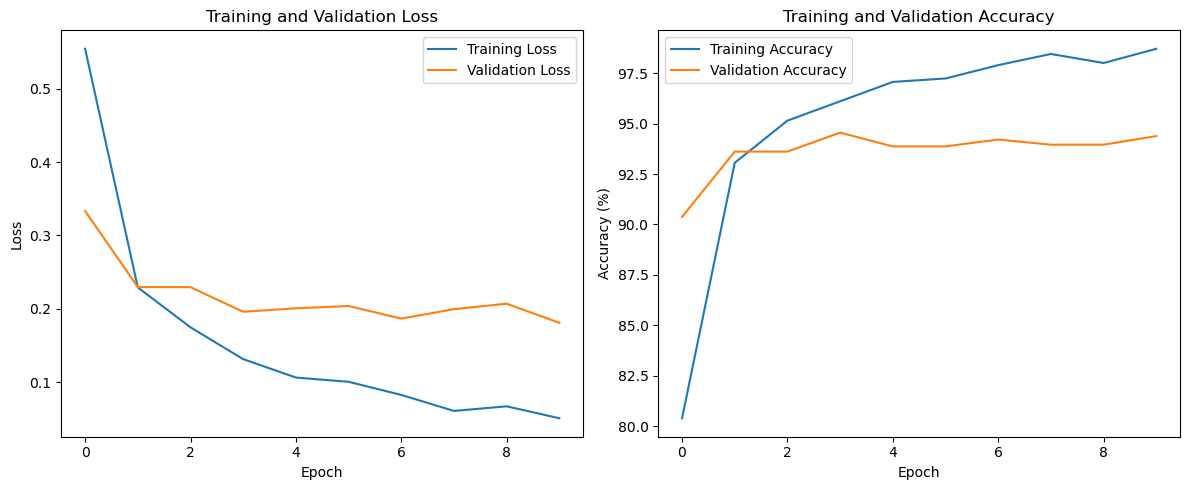

Val Accuracy: 94.38%

Creating confusion matrices...
Successfully saved: checkpoints/timesnet_classifier_confusion_matrix.png


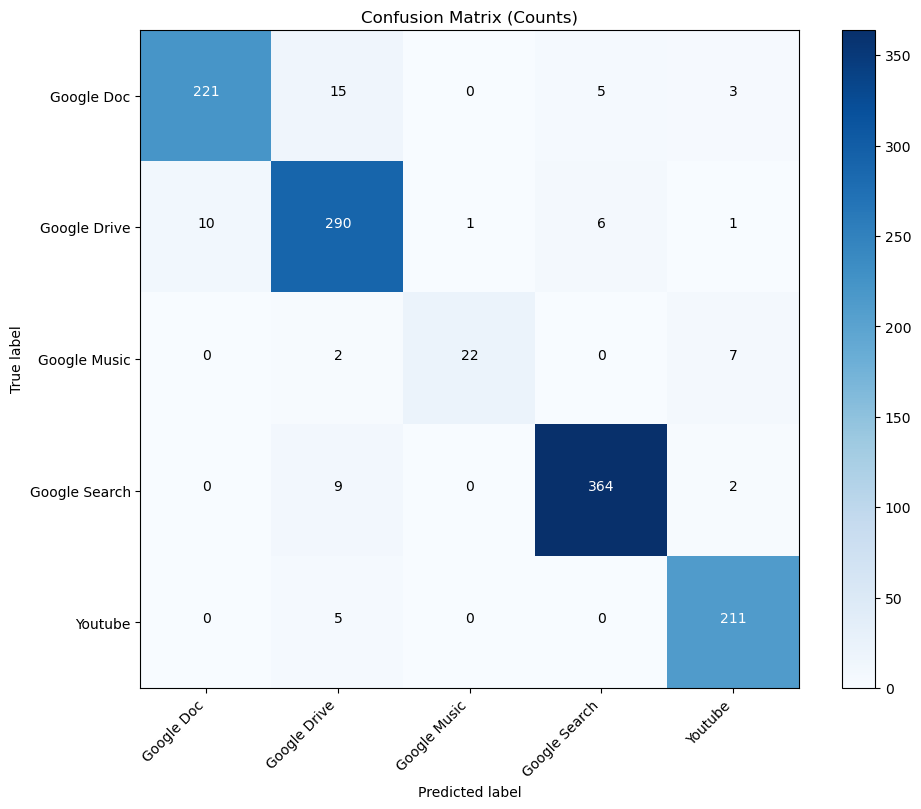

Successfully saved: checkpoints/timesnet_classifier_confusion_matrix_percent.png


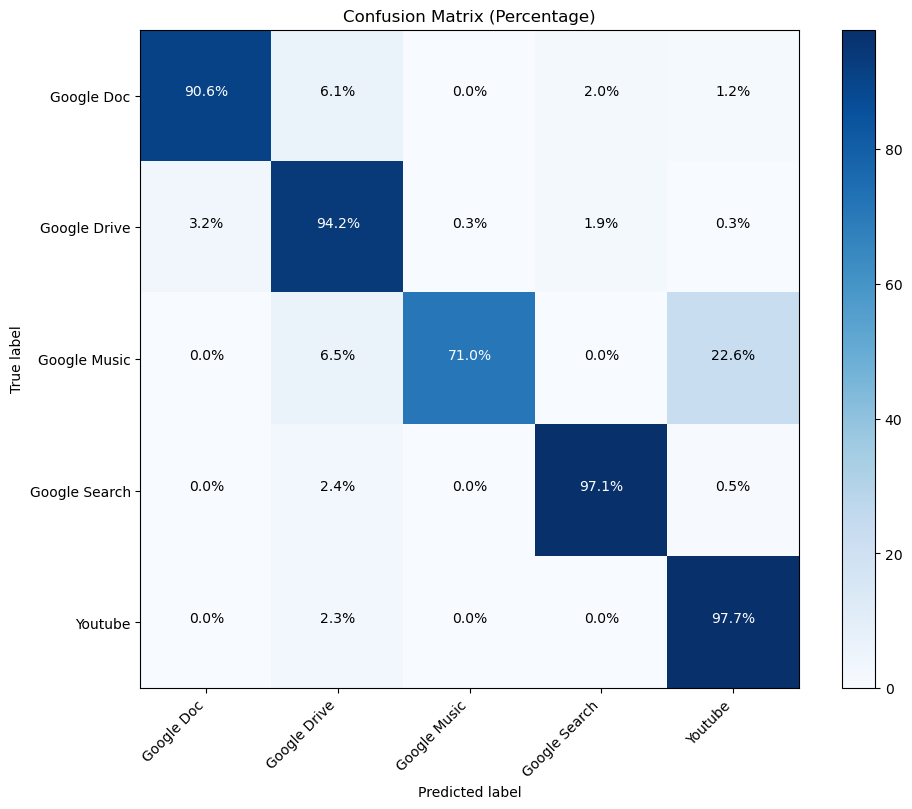


Evaluation Complete!
Total evaluation time: 0:00:01.705696


In [36]:
timesnet_model, timesnet_best_val_acc = train_classifier(train_loader, val_loader, timesnet_config, model=timesnet_model)

In [28]:
del timesnet_model, timesnet_best_val_acc

=== Debugging Information ===


Input shape: torch.Size([32, 401, 1])
Label shape: torch.Size([32])
Input range: 0.0 to 117824.0
=== End Debugging Info ===


Training:  10%|█         | 1/10 [00:05<00:46,  5.22s/it, train_loss=0.6705, train_acc=75.93%, val_loss=0.3982, val_acc=87.48%, time=0:00:05]

Saving checkpoint to checkpoints/nst_classifier_best.pth
Successfully saved checkpoint
Epoch 1/10
Training Loss: 0.6705, Accuracy: 75.93%
Validation Loss: 0.3982, Accuracy: 87.48%
Epoch time: 0:00:05.218790
----------------------------------------


Training:  20%|██        | 2/10 [00:10<00:41,  5.13s/it, train_loss=0.3298, train_acc=90.10%, val_loss=0.2997, val_acc=89.86%, time=0:00:05]

Saving checkpoint to checkpoints/nst_classifier_best.pth
Successfully saved checkpoint
Epoch 2/10
Training Loss: 0.3298, Accuracy: 90.10%
Validation Loss: 0.2997, Accuracy: 89.86%
Epoch time: 0:00:05.071672
----------------------------------------


Training:  30%|███       | 3/10 [00:15<00:35,  5.13s/it, train_loss=0.2475, train_acc=92.20%, val_loss=0.2532, val_acc=92.08%, time=0:00:05]

Saving checkpoint to checkpoints/nst_classifier_best.pth
Successfully saved checkpoint
Epoch 3/10
Training Loss: 0.2475, Accuracy: 92.20%
Validation Loss: 0.2532, Accuracy: 92.08%
Epoch time: 0:00:05.129327
----------------------------------------


Training:  40%|████      | 4/10 [00:20<00:30,  5.12s/it, train_loss=0.1920, train_acc=94.25%, val_loss=0.2316, val_acc=93.10%, time=0:00:05]

Saving checkpoint to checkpoints/nst_classifier_best.pth
Successfully saved checkpoint
Epoch 4/10
Training Loss: 0.1920, Accuracy: 94.25%
Validation Loss: 0.2316, Accuracy: 93.10%
Epoch time: 0:00:05.090404
----------------------------------------


Training:  50%|█████     | 5/10 [00:25<00:25,  5.11s/it, train_loss=0.1553, train_acc=95.46%, val_loss=0.2192, val_acc=93.61%, time=0:00:05]

Saving checkpoint to checkpoints/nst_classifier_best.pth
Successfully saved checkpoint
Saving checkpoint to checkpoints/nst_classifier_epoch_5.pth
Successfully saved checkpoint
Epoch 5/10
Training Loss: 0.1553, Accuracy: 95.46%
Validation Loss: 0.2192, Accuracy: 93.61%
Epoch time: 0:00:05.089525
----------------------------------------


Training:  60%|██████    | 6/10 [00:29<00:19,  4.76s/it, train_loss=0.1259, train_acc=96.14%, val_loss=0.2378, val_acc=93.44%, time=0:00:04]

Epoch 6/10
Training Loss: 0.1259, Accuracy: 96.14%
Validation Loss: 0.2378, Accuracy: 93.44%
Epoch time: 0:00:04.074606
----------------------------------------


Training:  70%|███████   | 7/10 [00:33<00:13,  4.41s/it, train_loss=0.1085, train_acc=97.08%, val_loss=0.2234, val_acc=93.61%, time=0:00:03]

Epoch 7/10
Training Loss: 0.1085, Accuracy: 97.08%
Validation Loss: 0.2234, Accuracy: 93.61%
Epoch time: 0:00:03.701678
----------------------------------------


Training:  80%|████████  | 8/10 [00:37<00:08,  4.21s/it, train_loss=0.1133, train_acc=96.76%, val_loss=0.2148, val_acc=93.87%, time=0:00:03]

Saving checkpoint to checkpoints/nst_classifier_best.pth
Successfully saved checkpoint
Epoch 8/10
Training Loss: 0.1133, Accuracy: 96.76%
Validation Loss: 0.2148, Accuracy: 93.87%
Epoch time: 0:00:03.777517
----------------------------------------


Training:  90%|█████████ | 9/10 [00:41<00:04,  4.10s/it, train_loss=0.0975, train_acc=97.25%, val_loss=0.2140, val_acc=93.87%, time=0:00:03]

Epoch 9/10
Training Loss: 0.0975, Accuracy: 97.25%
Validation Loss: 0.2140, Accuracy: 93.87%
Epoch time: 0:00:03.862882
----------------------------------------


Training: 100%|██████████| 10/10 [00:44<00:00,  4.48s/it, train_loss=0.0925, train_acc=97.40%, val_loss=0.2356, val_acc=92.76%, time=0:00:03]


Saving checkpoint to checkpoints/nst_classifier_epoch_10.pth
Successfully saved checkpoint
Epoch 10/10
Training Loss: 0.0925, Accuracy: 97.40%
Validation Loss: 0.2356, Accuracy: 92.76%
Epoch time: 0:00:03.787634
----------------------------------------

Training Complete!
Total training time: 0:00:45.115271

Plotting Training Metrics...
Saving metrics plot to: checkpoints/nst_classifier_training_metrics.png
Successfully saved metrics plot


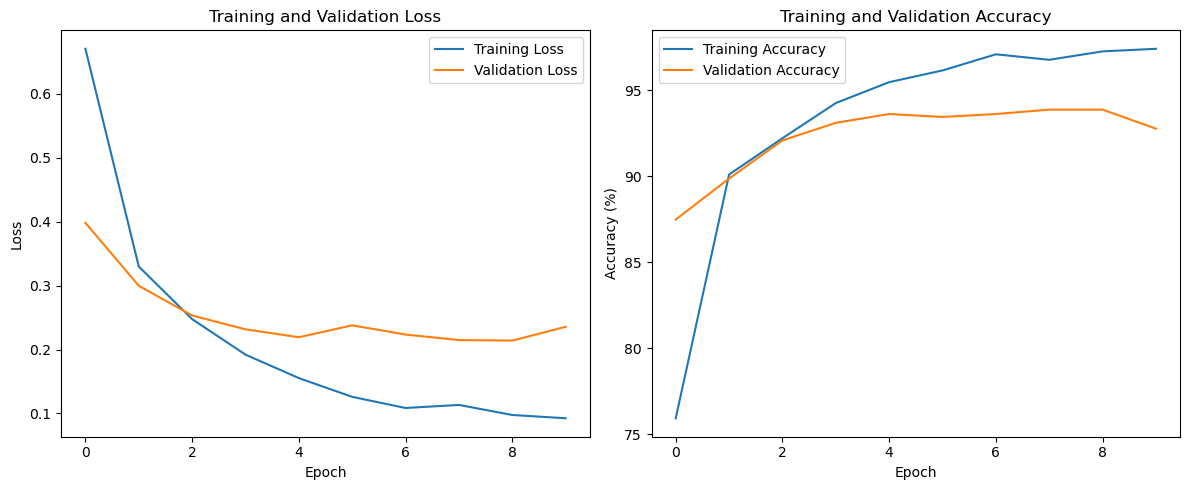

Val Accuracy: 92.76%

Creating confusion matrices...
Successfully saved: checkpoints/nst_classifier_confusion_matrix.png


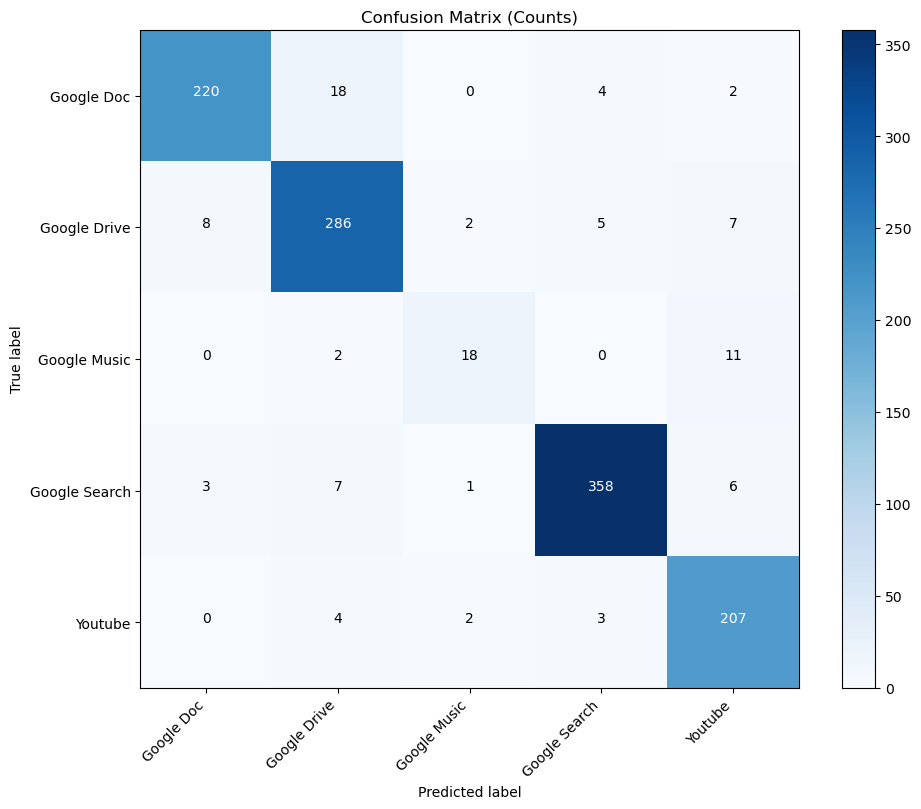

Successfully saved: checkpoints/nst_classifier_confusion_matrix_percent.png


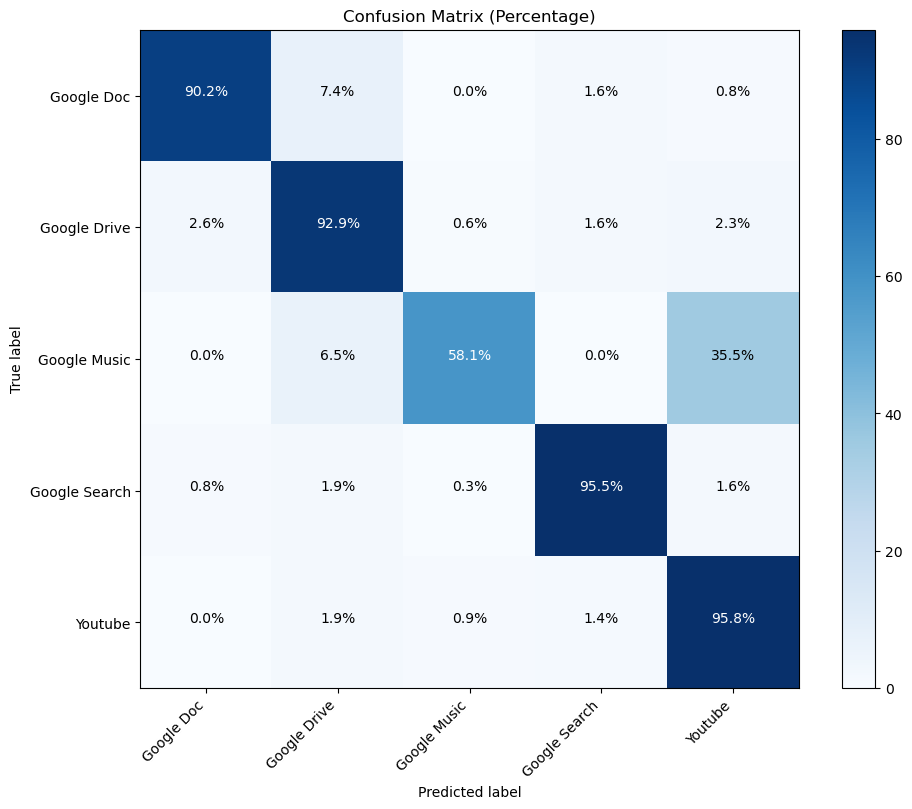


Evaluation Complete!
Total evaluation time: 0:00:00.457013


In [37]:
nst_model, nst_best_val_acc = train_classifier(train_loader, val_loader, nst_config)